In [2]:
# what was the change in price of stock overtime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline


In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\roots\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [3]:
pip install pandas-datareader


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\roots\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [3]:
from pandas_datareader.data import DataReader

In [4]:
from pandas_datareader import data as pdr

In [5]:
import yfinance as yf

In [6]:
from datetime import date as dt
import tensorflow as tf
import time as tm
from datetime import timedelta as td

In [7]:
from sklearn.preprocessing import MinMaxScaler
from collections import deque

In [8]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

In [9]:
N_STEPS=7
LOOKUP_STEPS=[1,2,3]

STOCK='GOOGL'

today=dt.today()

start_date=today-td(days=3*365)

start_str=start_date.strftime('%Y-%m-%d')
end_str=today.strftime('%Y-%m-%d')






In [10]:
df=yf.download(STOCK,
              start=start_str,
              end=end_str
              )

[*********************100%%**********************]  1 of 1 completed


In [11]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-08-18,136.500000,137.104507,135.321503,135.449005,135.293732,19258000
2021-08-19,134.435501,136.352493,134.250000,135.679993,135.524460,21782000
2021-08-20,136.000000,137.554001,135.250000,137.429504,137.271957,31194000
2021-08-23,137.969498,140.874496,137.607498,140.041504,139.880966,28454000
2021-08-24,140.611496,142.080002,140.338501,141.261505,141.099564,19268000
...,...,...,...,...,...,...
2024-08-12,164.350006,164.899994,161.839996,162.289993,162.289993,15895300
2024-08-13,163.410004,164.729996,162.970001,164.160004,164.160004,18551700
2024-08-14,162.399994,163.220001,157.710007,160.369995,160.369995,40591100


In [12]:
df=df.drop(['Open','High','Low','Adj Close','Volume'],axis=1)
df['date']=df.index

In [13]:
df

,Close,date
Date,,
2021-08-18,135.449005,2021-08-18
2021-08-19,135.679993,2021-08-19
2021-08-20,137.429504,2021-08-20
2021-08-23,140.041504,2021-08-23
2021-08-24,141.261505,2021-08-24
...,...,...
2024-08-12,162.289993,2024-08-12
2024-08-13,164.160004,2024-08-13
2024-08-14,160.369995,2024-08-14


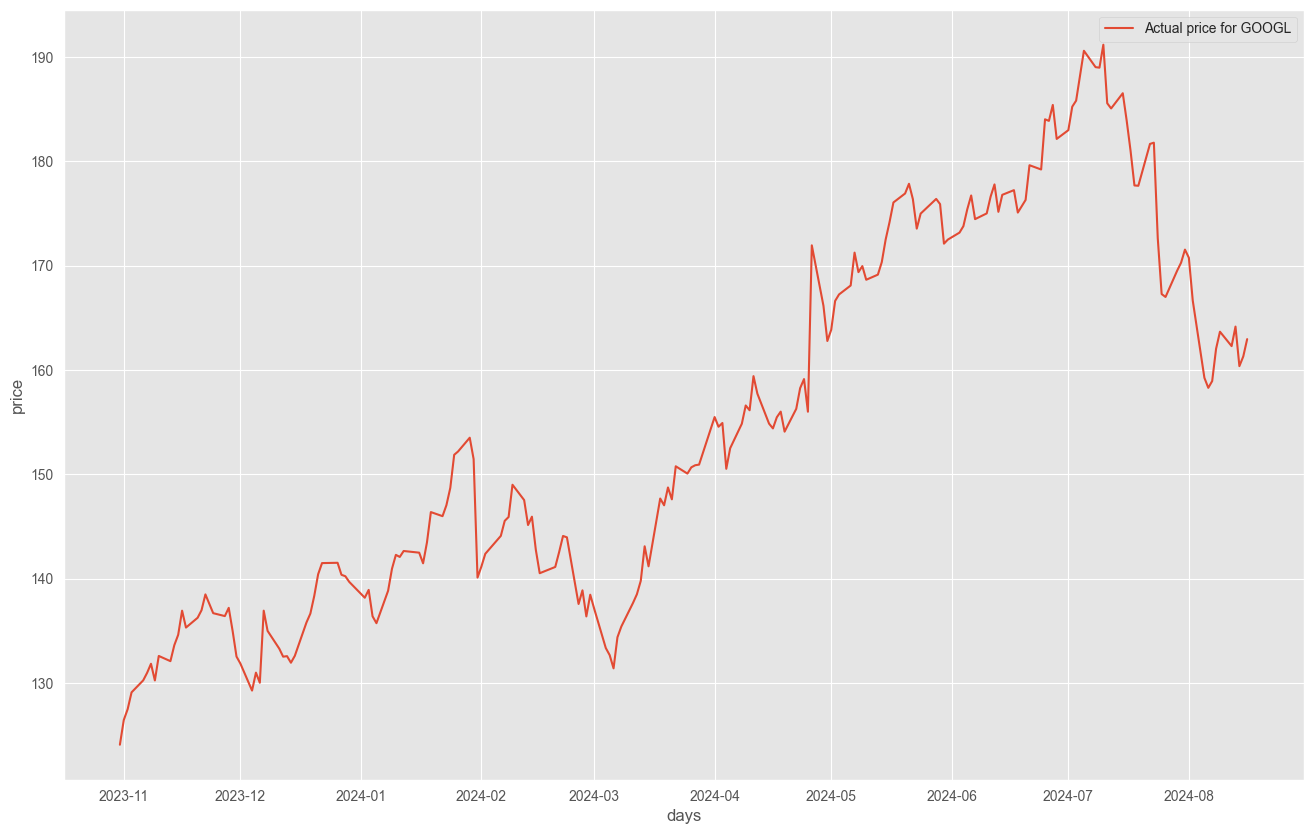

In [14]:
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(df['Close'][-200:])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCK}' ])
plt.show()

In [15]:
#scaling
scaler=MinMaxScaler()
df['Close']=scaler.fit_transform(np.expand_dims(df['Close'].values,axis=1))

In [16]:
def PrepareData(days):
    df1=df.copy()
    df1['Future']=df1['Close'].shift(-days)
    
    last_sequence=np.array(df1[['Close']].tail(days))
    df1.dropna(inplace=True)
    sequence_data=[]
    sequences=deque(maxlen=N_STEPS)

    for entry,target in zip(df1[['Close']+['date']].values,df1['Future'].values):
        sequences.append(entry)
        if len(sequences)==N_STEPS:
            sequence_data.append([np.array(sequences),target])
            
    last_sequence=list([s[:len(['close'])] for s in sequences]) + list(last_sequence)
    last_sequence=np.array(last_sequence).astype(np.float32)

    X,Y= [],[]
    for seq,target in sequence_data:
        X.append(seq)
        Y.append(target)

    X=np.array(X)
    Y=np.array(Y)

    return df1,last_sequence,X,Y
        

     

In [28]:
import keras
def GetTrainedModel(x_train,y_train):
    model=Sequential()
    model.add(keras.Input(shape=(N_STEPS, len(['close']))))
    model.add(LSTM(60,return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(120,return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(20))
    model.add(Dense(1))

   

    model.compile(loss='mean_squared_error',optimizer='adam')

    model.fit(x_train,y_train,
             batch_size=8,
             epochs=80,
             verbose=1
             )
    model.summary()
    return model

In [21]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\roots\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [39]:

predictions=[]

for step in LOOKUP_STEPS:
    df1,last_sequence,x_train,y_train=PrepareData(step).
    x_train=x_train[:,:,:len(['close'])].astype(np.float32)

    model=GetTrainedModel(x_train,y_train)
    last_sequence = last_sequence[-N_STEPS:]
    last_sequence = np.expand_dims(last_sequence, axis=0)
    prediction = model.predict(last_sequence)
    predicted_price = scaler.inverse_transform(prediction)[0][0]

    predictions.append(round(float(predicted_price), 2))
print(predictions)
    

Epoch 1/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0345
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0046
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0028
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0032
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0029
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0027
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0025
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0020
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0023
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0020
Epoch 13/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0020
Epoch 14/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0021
Epoch 15/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016
Epoch 16/80
94/94 ━

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                       │ (None, 7, 60)               │          14,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 7, 60)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 120)                 │          86,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 20)                  │           2,420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
Epoch 1/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0323
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0025
Epoch 13/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0031
Epoch 14/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024
Epoch 15/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                       │ (None, 7, 60)               │          14,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 7, 60)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 120)                 │          86,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 20)                  │           2,420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
Epoch 1/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0382
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026
Epoch 13/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029
Epoch 14/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038
Epoch 15/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                       │ (None, 7, 60)               │          14,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 7, 60)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 120)                 │          86,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 20)                  │           2,420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
[161.82, 161.89, 161.25]
